In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

Valeur V₀(W₀=10.0) ≈ 6.43662
π₀ optimal (via DP) ≈ 0.45295
π* Merton (continu) = 0.44444
Écart relatif (%) = 1.91


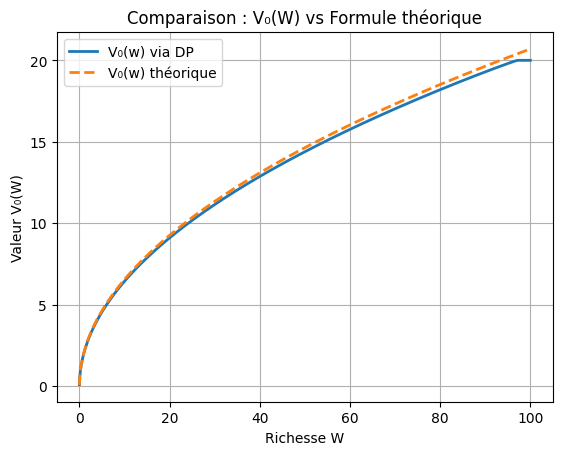

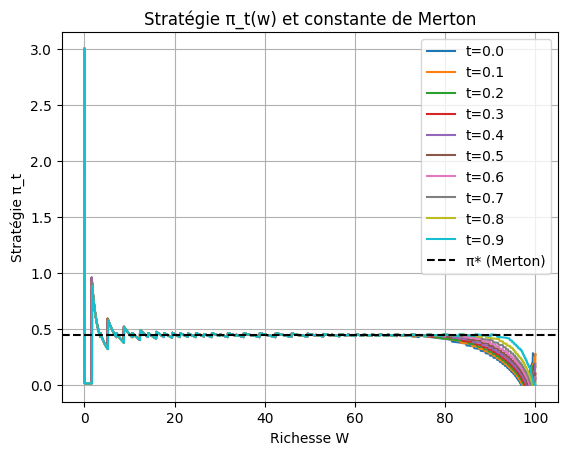

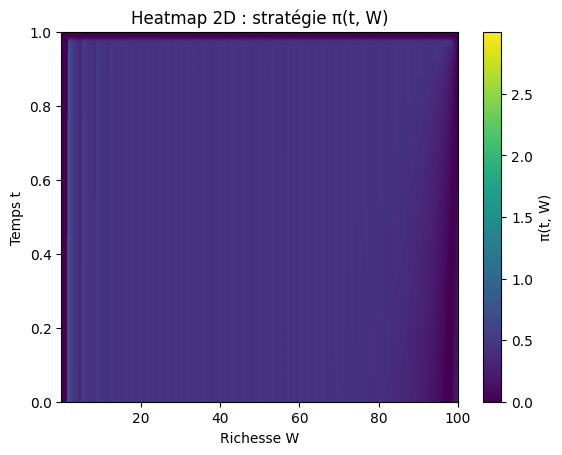

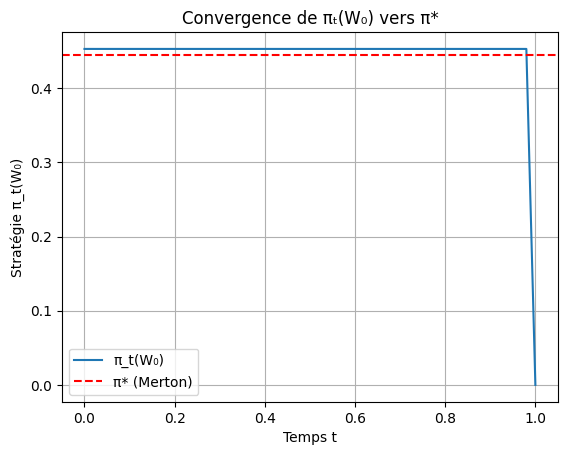

In [3]:
# === Paramètres ===
r = 0.03
mu = 0.05
sigma = 0.30
gamma = 0.5
p = 0.5
W0 = 10.0

T = 1.0
n = 50
delta_t = T / n


# === Grille de richesse ===
W_min, W_max = 1e-3, 100.0
W_grid = np.linspace(W_min, W_max, 1500)

# === Utilité CRRA ===
def u(w, gamma):
    if w <= 0:
        return -np.inf
    return w**(1 - gamma) / (1 - gamma) if gamma != 1 else np.log(w)

# === Formule théorique V_explicit ===
def V_explicit(t, T, r, alpha, sigma, S, W, gamma, K=1):
    v = 0.5 * ((alpha - r) / sigma)**2 * 1/(1 - gamma) + r
    g = np.exp(v * (T - t))
    return g * (W**gamma) / gamma

# === Initialisation V_n ===
V = {n: {w: u(w, gamma) for w in W_grid}}
pi_store = {n: {w: 0 for w in W_grid}}

# === Programmation dynamique ===
for t in reversed(range(n)):
    V[t] = {}
    pi_store[t] = {}
 
    for w in W_grid:
        def objective(pi):
            A = 1 + r * delta_t
            B = (mu - r) * delta_t
            C = sigma * np.sqrt(delta_t)
            
            W_up = w * (A + pi * (B + C))
            W_down = w * (A + pi * (B - C))
            if W_up <= 0 or W_down <= 0:
                return np.inf

            V_up = np.interp(W_up, W_grid, list(V[t+1].values()))
            V_down = np.interp(W_down, W_grid, list(V[t+1].values()))

            return -(p * V_up + (1 - p) * V_down)

        res = minimize_scalar(objective, bounds=(0, 3), method='bounded')
        pi_opt = res.x
        V_opt = -res.fun
        
        V[t][w] = V_opt
        pi_store[t][w] = pi_opt

 

# === Extraction à t = 0 pour W0 ===
w_closest = W_grid[np.argmin(np.abs(W_grid - W0))]
V0 = V[0][w_closest]
pi_0_opt = pi_store[0][w_closest]


# === Formule de Merton ===
pi_merton = (mu - r) / (gamma * sigma**2)
rel_error = 100 * abs(pi_0_opt - pi_merton) / abs(pi_merton)

print(f"Valeur V₀(W₀={W0}) ≈ {round(V0, 5)}")
print(f"π₀ optimal (via DP) ≈ {round(pi_0_opt, 5)}")
print(f"π* Merton (continu) = {round(pi_merton, 5)}")
print(f"Écart relatif (%) = {round(rel_error, 2)}")

# === 1. Affichage de V₀(W) et V_explicit ===
V0_list = [V[0][w] for w in W_grid]
V_theo_list = [V_explicit(0, T, r, mu, sigma, 0, w, gamma) for w in W_grid]

 
plt.plot(W_grid, V0_list, label="V₀(w) via DP", linewidth=2)
plt.plot(W_grid, V_theo_list, '--', label="V₀(w) théorique", linewidth=2)
plt.xlabel("Richesse W")
plt.ylabel("Valeur V₀(W)")
plt.title("Comparaison : V₀(W) vs Formule théorique")
plt.grid(True)
plt.legend()
plt.show()

# === 2. Stratégies π_t(w) avec droite Merton ===
for t in range(0, n, max(1, n//10)):
    pi_values = [pi_store[t][w] for w in W_grid]
    plt.plot(W_grid, pi_values, label=f't={round(t*delta_t,2)}')

 
plt.axhline(pi_merton, color='black', linestyle='--', label="π* (Merton)")
plt.title("Stratégie π_t(w) et constante de Merton")
plt.xlabel("Richesse W")
plt.ylabel("Stratégie π_t")
plt.legend()
plt.grid(True)
plt.show()

 
# === 3. Heatmap π(t, W) ===
heatmap = np.zeros((n+1, len(W_grid)))
for t in range(n+1):
    heatmap[t, :] = [pi_store[t][w] for w in W_grid]


plt.imshow(heatmap, aspect='auto', origin='lower', extent=[W_min, W_max, 0, T], cmap='viridis')
plt.colorbar(label="π(t, W)")
plt.xlabel("Richesse W")
plt.ylabel("Temps t")
plt.title("Heatmap 2D : stratégie π(t, W)")
plt.show()


# === 4. Convergence de π_t(W₀) vers π* ===
pi_w0_list = [pi_store[t][w_closest] for t in range(n+1)]
t_grid = np.linspace(0, T, n+1)

 
plt.plot(t_grid, pi_w0_list, label="π_t(W₀)")
plt.axhline(pi_merton, linestyle='--', color='red', label="π* (Merton)")
plt.xlabel("Temps t")
plt.ylabel("Stratégie π_t(W₀)")
plt.title("Convergence de πₜ(W₀) vers π*")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
pi_val = []
for t in range(n):
    pi_val.append([pi_store[t][w] for w in W_grid])

In [ ]:
pi_val